<p style="text-align: center; font-size: 30px;">
    <strong>
          Analysis of user reviews on Amazon.es
    </strong>
</p>


<b style="text-align: left; font-size: 18px;">
    This project has been called into existence to provide a comprehensive evaluation of coffee machines reviews for Amazon.es
</b>

----

<b style="font-size: 20px;">Project Roadmap</b>

-  <p style="font-size: 18px;">Clear the databse of irrelevant reviews</p>
-  <p style="font-size: 18px;">Classify reviews in every category as postive, neutral or negative (sentiment analysis)</p>
-  <p style="font-size: 18px;">Outline the most heated topics amongst customers of every category (topic modeling) </p>
---

<b style="font-size: 20px;">Required tools</b>

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Langdetect library for text classification by language 
</blockquote>

In [ ]:
!pip install langdetect

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Pandas library for data storage and manipulation
</blockquote>

In [ ]:
!pip install pandas

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    TQDM library for progress check 
</blockquote>

In [ ]:
!pip install tqdm

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Spacy library for natural language processing 
</blockquote>

In [ ]:
!pip install spacy

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    TextBlob library for natural language analysing 
</blockquote>

In [ ]:
!pip install textblob

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Pysentimiento for sentiment analysis
</blockquote>

In [ ]:
!pip install pysentimiento

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Matplotlib for graphs
</blockquote>

In [ ]:
!pip install matplotlib

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Transformers for pipeline (easy interaction with models based on the Transformer architecture)
</blockquote>

In [ ]:
!pip install transformers

<blockquote style="background-color: #f0f0f0; padding: 10px; border-left: 10px solid #3498db; font-size: 18px;">
    Wordcloud and pyLDAvis for data demonstration 
</blockquote>

In [ ]:
!pip install wordcloud

In [ ]:
!pip install pyLDAvis

---
<b style="font-size: 20px;">Importing necessary libraries </b>

In [59]:
from langdetect import detect
from textblob import TextBlob
from pysentimiento import create_analyzer
from transformers import pipeline
import spacy

import pandas as pd
from tqdm import tqdm
import os

from IPython.display import display, HTML
import matplotlib.pyplot as plt

import time
import datetime

import gensim
from gensim import corpora
from gensim.models.callbacks import CallbackAny2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
import re
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

---
<b style="font-size: 20px;">
    Clearing the new database of non spanish reviews
</b>

In [12]:
from tqdm import tqdm

def is_spanish(text):
    try:
        return detect(text) == 'es'
    except: #en caso de error o idioma no detectado
        return False

def filter_reseñas_esp(filename):
    df = pd.read_csv(filename)
    count_original = df.shape[0]
    
    filtered_df = df[df["body"].apply(is_spanish)]
    count_final = filtered_df.shape[0]

    if count_final > 0:
        filtered_df.to_csv(filename, index=False, encoding="utf-8")
    else:
        df.head(0).to_csv(filename, index=False, encoding="utf-8")

    diff = count_original - count_final 
    return (filtered_df, diff)

if __name__ == "__main__":
    base_df = pd.read_csv('new_database/base.csv')

    dataframes = []

    for ID in base_df['ID']:
        id_df = pd.read_csv(f'new_database/{ID}.csv')
        category = base_df.loc[base_df['ID'] == ID, 'category'].values

        reviews_df = pd.DataFrame()

        for local_id in tqdm(id_df['ID'], desc=f"Processing local_IDs for {ID}.csv"):
            review_filename = f'new_database/reviews/{local_id}.csv'
        
            (filtered_df, count) = filter_reseñas_esp(review_filename)

            reviews_df = pd.concat([reviews_df, filtered_df], ignore_index=True)
        
        print('-'*50 + f'\nReviews left in the {category[0]} category: {reviews_df.shape[0]}\n')
        dataframes.append(reviews_df)

    for i in range(len(dataframes)):
        dataframes[i].to_csv(f'new_database/analysis/category_{i}.csv', index = False, encoding = "utf-8")

Processing local_IDs for 0.csv: 100%|█████████| 279/279 [04:04<00:00,  1.14it/s]


--------------------------------------------------
Reviews left in the Cafeteras de goteo category: 20495



Processing local_IDs for 1.csv: 100%|███████████| 98/98 [02:16<00:00,  1.40s/it]


--------------------------------------------------
Reviews left in the Cafeteras automaticas category: 16073



Processing local_IDs for 2.csv: 100%|█████████| 148/148 [02:37<00:00,  1.07s/it]


--------------------------------------------------
Reviews left in the Cafeteras individuales category: 19085



In [14]:
base_df = pd.read_csv('new_database/base.csv')
all_reviews = pd.DataFrame()

for ID in base_df['ID']:
    id_df = pd.read_csv(f'new_database/{ID}.csv')
    category = base_df.loc[base_df['ID'] == ID, 'category'].values
    
    reviews_df = pd.DataFrame()
    
    for local_id in id_df['ID']:
        review_file = f'new_database/reviews/{local_id}.csv'
        
        if os.path.exists(review_file):
            try:
                review_df = pd.read_csv(review_file)
            except:
                print(f'Error parsing {review_file}')
                continue
            reviews_df = pd.concat([reviews_df, review_df], ignore_index=True)
    
    print(f'Located {len(reviews_df)} reviews in {category[0]} category.')

    all_reviews = pd.concat([all_reviews, reviews_df], ignore_index=True)

print('-'*50 + f'\nTotal number of reviews in the new_database: {len(all_reviews)}\n' + '-'*50)

all_reviews.head()

Located 20495 reviews in Cafeteras de goteo category.
Located 16073 reviews in Cafeteras automaticas category.
Located 19085 reviews in Cafeteras individuales category.
--------------------------------------------------
Total number of reviews in the new_database: 55653
--------------------------------------------------


title              rating  \
0                                             Regalo  5,0 de 5 estrellas   
1  No ha durado ni la garantía + pésimo servicio ...  1,0 de 5 estrellas   
2                                          Está bien  3,0 de 5 estrellas   
3                                          Perfecta!  5,0 de 5 estrellas   
4                                          EXCELENTE  5,0 de 5 estrellas   

                                                body          author  \
0                                     Me gustó mucho  Cliente Amazon   
1  Ni los 24 meses de garantía ha durado, y al en...             MaX   
2  Después de más de dos meses usándola hace muy ...          Lorena   
3  Me encanta! Soy adicta al café y me gusta toma...       Perfecta!   
4  como única pega que limpiar el palito del vapo...          Sil at   

                                          date  
0     Revisado en España el 6 de abril de 2024  
1     Revisado en España el 3 de abril de 2024  
2    Revisado en España el 14 de marzo de 2024  
3  Revisado en España el 22 de febrero de 2024  
4  Revisado en España el 20 de febrero de 2024

----
<p style="text-align: center; font-size: 25px; margin-top: 20px;">
    <strong>
          Sentiment analysis 
    </strong>
</p>

----


<b style="font-size: 20px;">
    Displaying charts and graphs
</b>
<p style="font-size: 18px;">Defining functions for easy demostration of the results.</p>

In [117]:
def show_pie_chart(polarities):
    base = pd.read_csv("new_database/base.csv") # naming categories
    categories = []
    
    for i in base["category"]:
        categories.append(i)

    labels = ['Positive', 'Neutral', 'Negative']
    fig, axis = plt.subplots(1, 3, figsize=(18, 6)) # creating a shape and an axis

    for i, (ax, data) in enumerate(zip(axis, polarities)):
        ax.pie(data, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99','#ff6666'])
        ax.set_title(categories[i])

    plt.tight_layout() #showing diagrams
    plt.show()

def load_polarities_from_csv(type):
    polarities = []
    for i in range(3):
        
        df = pd.read_csv(f'new_database/analysis/analyzed_category_{i}.csv')

        if type not in df.columns: # that column might not exist
            raise ValueError(f"Column '{type}' does not exist in the DataFrame.")

        counts = df[type].value_counts() # counting the number of different values in those columns 
    
        result = ( # making that into a cortege 
            counts.get('POS', 0),
            counts.get('NEU', 0),
            counts.get('NEG', 0)
        )

        polarities.append(result)
    
    return polarities

def show_comparison():
    base = pd.read_csv("new_database/base.csv") # naming categories
    categories = []
    
    for i in base["category"]:
        categories.append(i)

    for i in range(3):
        df = pd.read_csv(f'new_database/analysis/analyzed_category_{i}.csv')
    
        # Locating the first five mismatched words
        mismatched_reviews = df[df['Pysentimiento_sentiment'] != df['BERT_sentiment']].head(5)

        # Forming a title 
        text = f"Mismatched results for {categories[i]} category"
        html_code = f"""
        <b style="font-size: 20px;  margin-bottom: 20px;">
            <h1 style="font-size: 25px; text-align: center;">{text}</h1>
        </b>
        """
        display(HTML(html_code))
    
        # Displaying the table
        html_content = """
        <table style="width:100%; border-collapse: collapse; table-layout: auto;">
            <tr style="background-color: #f2f2f2; text-align: center;">
                <th style="border: 1px solid #dddddd; padding: 8px; text-align: center; width: 70%; font-size: 15px;">Review</th>
                <th style="border: 1px solid #dddddd; padding: 8px; text-align: center; width: 15%; font-size: 15px;">Pysentimiento Sentiment</th>
                <th style="border: 1px solid #dddddd; padding: 8px; text-align: center; width: 15%; font-size: 15px;">BERT Sentiment</th>
            </tr>
        """

        for index, row in mismatched_reviews.iterrows():
            html_content += f"""
            <tr>
                <td style="border: 1px solid #dddddd; padding: 8px; text-align: left;">{row['body']}</td>
                <td style="border: 1px solid #dddddd; padding: 8px; text-align: center;">{row['Pysentimiento_sentiment']}</td>
                <td style="border: 1px solid #dddddd; padding: 8px; text-align: center;">{row['BERT_sentiment']}</td>
            </tr>
            """

        html_content += "</table>"
    
        display(HTML(html_content))


---
<b style="font-size: 20px;">First approach: using TextBlob</b>

In [75]:
nlp = spacy.load('en_core_web_sm')

def analyze_sentiment_TextBlob(review):
    doc = nlp(review) # tokenizer 
    
    processed_review = " ".join([token.text for token in doc]) # adjusting tokenization for TextBlob

    blob = TextBlob(processed_review)
    
    polarity = blob.sentiment.polarity # getting polarity between -1.0 and 1.0

    if polarity > 0:
        return 'POS' # positive
    if polarity < 0:
        return 'NEG' # negative
    
    return 'NEU' # neutral



if __name__ == "__main__":
    
    start_time = time.perf_counter() 
    
    for i in range(3):
        df = pd.read_csv(f'new_database/analysis/category_{i}.csv')

        
        for j in tqdm(range(df.shape[0]), desc = f"Classifying reviews in category_{i}.csv"):
            polarity = analyze_sentiment_TextBlob(df.loc[j, 'body'])
            df.loc[j, 'TextBlob_sentiment'] = polarity

        df.to_csv(f'new_database/analysis/analyzed_category_{i}.csv', index = False, encoding = "utf-8")

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*50 + f'\nTime taken: {str(datetime.timedelta(seconds = elapsed_time))}')

Classifying reviews in category_0.csv: 100%|█| 20495/20495 [02:40<00:00, 127.58i
Classifying reviews in category_1.csv: 100%|█| 16073/16073 [03:00<00:00, 88.84it
Classifying reviews in category_2.csv: 100%|█| 19085/19085 [02:20<00:00, 135.60i


--------------------------------------------------
Time taken: 0:08:03.102918


---
<b style="font-size: 20px;">Second approach: using Pysentimiento</b>

In [80]:
analyzer = create_analyzer(task="sentiment", lang="es")
nlp = spacy.load('en_core_web_sm')

def analyze_sentiment_py(text):
    doc = nlp(text) # tokenizing 
    
    processed_review = " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space]) # preparation and filtration
    result = analyzer.predict(processed_review)

    #max_label = max(result.probabilities, key=result.probabilities.get) # choosing result with the highest probability 
    max_label = result.output
    
    return max_label

if __name__ == "__main__":
    start_time = time.perf_counter() 

    for i in range(3):

        df = pd.read_csv(f'new_database/analysis/analyzed_category_{i}.csv')
        
        for j in tqdm(range(df.shape[0]), desc = f"Classifying reviews in category_{i}.csv"):
            polarity = analyze_sentiment_py(df.loc[j, 'body'])
            df.loc[j,'Pysentimiento_sentiment'] = polarity

        df.to_csv(f'new_database/analysis/analyzed_category_{i}.csv', index = False, encoding = "utf-8")
                
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*50 + f'\nTime taken: {str(datetime.timedelta(seconds = elapsed_time))}')

Classifying reviews in category_0.csv: 100%|█| 20495/20495 [2:19:38<00:00,  2.45
Classifying reviews in category_1.csv: 100%|█| 16073/16073 [2:11:20<00:00,  2.04
Classifying reviews in category_2.csv: 100%|█| 19085/19085 [2:08:47<00:00,  2.47


--------------------------------------------------
Time taken: 6:39:48.097250


---
<b style="font-size: 20px;">Third approach: using a BERT-like model</b>

In [81]:
# Creating a pipeline for polarity analysis using BETO
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    #tokenizer_kwargs={"clean_up_tokenization_spaces": True}
)

def analyze_sentiment(review): # only viable for short texts (less than 512 tokens)
    result = sentiment_analysis(review)[0]
    label = result['label']
    
    if label == '1 star' or label == '2 stars':
        return -1 
    elif label == '4 stars' or label == '5 stars':
        return 1
    else:
        return 0

def analyze_sentiment_long_text(review, chunk_size=512): # splitting texts into chunks and finding an average polarity
    chunks = [review[i:i + chunk_size] for i in range(0, len(review), chunk_size)]
    sentiments = []
    
    for chunk in chunks:
        result = sentiment_analysis(chunk)[0]
        label = result['label']
        if label == '1 star' or label == '2 stars':
            sentiments.append(-1)  # Negative
        elif label == '4 stars' or label == '5 stars':
            sentiments.append(1)  # Positive
        else:
            sentiments.append(0)  # Neutral
    
    total = sum(sentiments) / len(sentiments)

    if total > 0:
        return 'POS'
    elif total < 0:
        return 'NEG'
    else:
        return 'NEU'

if __name__ == "__main__":

    start_time = time.perf_counter()
    
    polarities_df = pd.DataFrame(columns=["Positive", "Neutral", "Negative"])
    
    for i in range(3):
        df = pd.read_csv(f'new_database/analysis/analyzed_category_{i}.csv')

        for j in tqdm(range(df.shape[0]), desc=f"Processing reviews in category_{i}.csv"):
            polarity = analyze_sentiment_long_text(df.loc[j, 'body'])
            df.loc[j, 'BERT_sentiment'] = polarity

        df.to_csv(f'new_database/analysis/analyzed_category_{i}.csv', index = False, encoding = "utf-8")

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*50 + f'\nTime taken: {str(datetime.timedelta(seconds = elapsed_time))}')

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing reviews in category_0.csv: 100%|█| 20495/20495 [51:39<00:00,  6.61it/
Processing reviews in category_1.csv: 100%|█| 16073/16073 [1:02:05<00:00,  4.31i
Processing reviews in category_2.csv: 100%|█| 19085/19085 [44:53<00:00,  7.09it/


--------------------------------------------------
Time taken: 2:38:38.862371


---
<b style="font-size: 20px;">Demostration of all approaches</b>

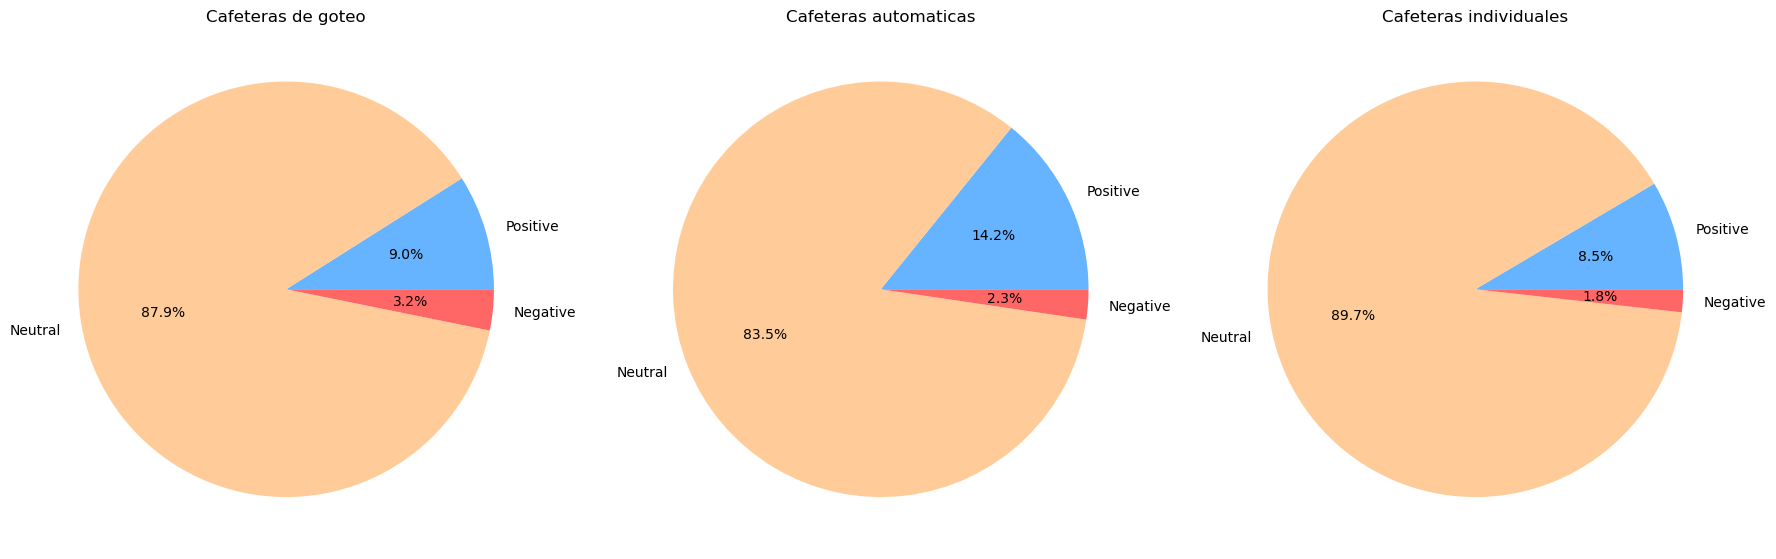

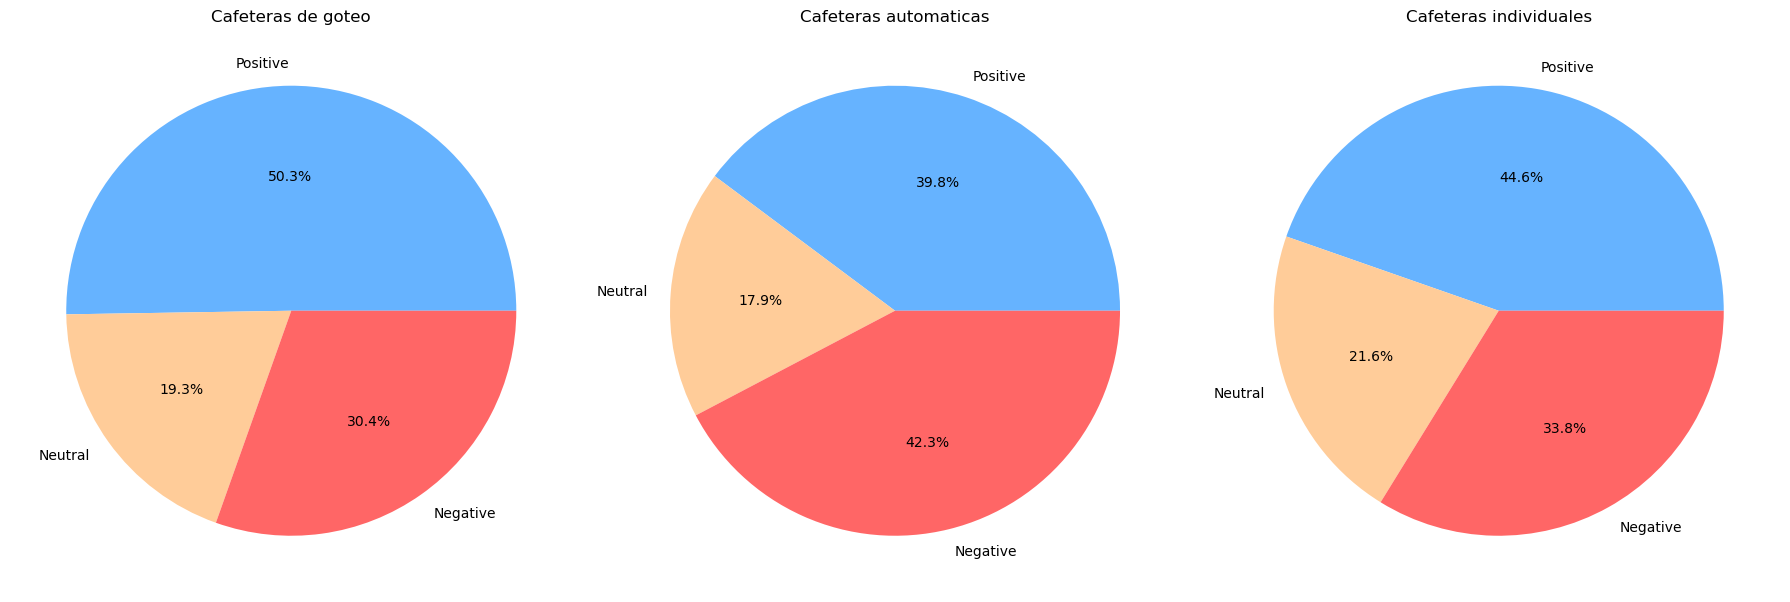

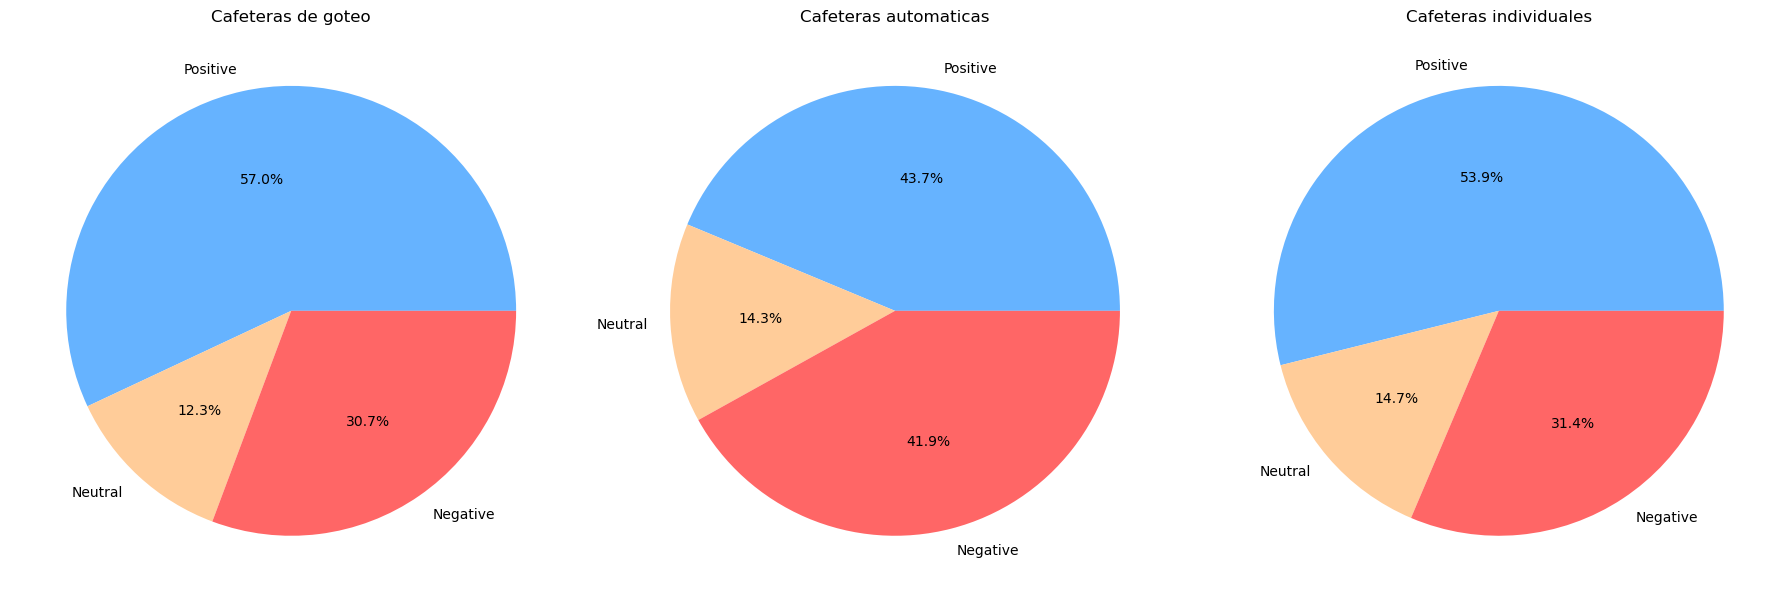

In [98]:
types = ['TextBlob_sentiment', 'Pysentimiento_sentiment', 'BERT_sentiment']

for i in range(3):
    polarities = load_polarities_from_csv(types[i])

    text = f'Result from {types[i]}:'
    html_code = f"""
    <b style="font-size: 20px;">
        <h1 style="font-size: 25px; text-align: center;">{text}</h1>
    </b>
    """
    display(HTML(html_code))

    show_pie_chart(polarities)
    

---
<b style="font-size: 20px;">
    Comparison of all approaches
</b>

<p style="font-size: 18px;">The results provided by TextBlob seem to be way off the point, due to the fact that this model has only been trained on english texts.</p>
<p style="font-size: 18px;  margin-top: -20px;">However, it's worth comparing Pysentimiento and BERT</p>

In [118]:
show_comparison()

----
<p style="text-align: center; font-size: 25px; margin-top: 20px;">
    <strong>
          Topic modelling with Latent Dirichlet Allocation (LDA)
    </strong>
</p>

---

In [46]:
def save_lda_topics(lda_model, file_name, num_words = 10): 
    # Getting topics with probabilities
    topics = lda_model.show_topics(num_topics=lda_model.num_topics, num_words=num_words, formatted=False)

    # Preparing data for saving 
    data = {}
    for topic_num, words in topics:
        # Reverse sorting
        sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
        
        # A string from wirds and prob
        topic_representation = [f"{word} ({prob:.4f})" for word, prob in sorted_words]
        
        data[f"Topic {topic_num}"] = topic_representation

    df = pd.DataFrame(data)
    df.to_csv(file_name, index=False)

    print(f"Topics save successfully at {file_name}")

# Preparing the text
def preprocess(text):
    stop_words = set(stopwords.words('spanish')) 
    
    # Adding stop words
    additional_stop_words = ['bien', 'cafetera', 'máquina', 'si', 'do', 'hace' ,'amazon', 'ademas', 'café']
    stop_words.update(additional_stop_words)
    
    lemmatizer = WordNetLemmatizer() # lemmatization 
    words = word_tokenize(text.lower()) # tokenizaer
    
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha()] # tokenization
    words = [word for word in words if word not in stop_words] # filtering stop words
    
    return words


if __name__ == "__main__": 

    start_time = time.perf_counter()
    
    for i in range(3): 
        
        data = pd.read_csv(f'new_database/analysis/category_{i}.csv') 
    
        # processing reviews 
        data['processed_body'] = None 
        for j in tqdm(range(len(data)),  desc = f"Preprocessing reviews in category_{i}.csv"): 
            data.at[j, 'processed_body'] = preprocess(data.loc[j, 'body'])

    
        # Creating a dictionary and a corpus (BoW = Bag of Words)
        dictionary = corpora.Dictionary(data['processed_body']) 
        corpus = [dictionary.doc2bow(text) for text in data['processed_body']] 

        # Creating an LDA model 
        num_topics = 10
        total_passes = 15

        lda_model = gensim.models.ldamodel.LdaModel(
            corpus = corpus, 
            num_topics = num_topics, 
            id2word = dictionary, 
            passes = 1, 
            iterations = 100
        )

        # Training model
        for epoch in tqdm(range(total_passes), desc="Training LDA model"):
            lda_model.update(corpus)
        
        print(f'LDA model {i} is done.\n' + '-'* 50)

        # Providing ten topics with ten words
        #print(f'Topics for {i} category:')
        topics = lda_model.print_topics(num_words = num_topics)

        # saving topics
        save_lda_topics(lda_model, f'new_database/analysis/LDA/LDA_category_{i}.csv', num_words = num_topics)

        #saving model
        lda_model.save(f'new_database/analysis/LDA/model_{i}.model')
        dictionary.save(f'new_database/analysis/LDA/dictionary_{i}.dict')
        corpora.MmCorpus.serialize(f'new_database/analysis/LDA/corpus_{i}.mm', corpus)

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print('-'*50 + f'\nTime taken: {str(datetime.timedelta(seconds = elapsed_time))}')

Preprocessing reviews in category_0.csv: 100%|█| 20495/20495 [00:14<00:00, 1438.
Training LDA model: 100%|███████████████████████| 15/15 [01:01<00:00,  4.11s/it]


LDA model 0 is done.
--------------------------------------------------
Topics save successfully at new_database/analysis/LDA/LDA_category_0.csv


Preprocessing reviews in category_1.csv: 100%|█| 16073/16073 [00:14<00:00, 1094.
Training LDA model: 100%|███████████████████████| 15/15 [00:53<00:00,  3.59s/it]


LDA model 1 is done.
--------------------------------------------------
Topics save successfully at new_database/analysis/LDA/LDA_category_1.csv


Preprocessing reviews in category_2.csv: 100%|█| 19085/19085 [00:12<00:00, 1545.
Training LDA model: 100%|███████████████████████| 15/15 [00:49<00:00,  3.27s/it]


LDA model 2 is done.
--------------------------------------------------
Topics save successfully at new_database/analysis/LDA/LDA_category_2.csv
--------------------------------------------------
Time taken: 0:03:45.451121


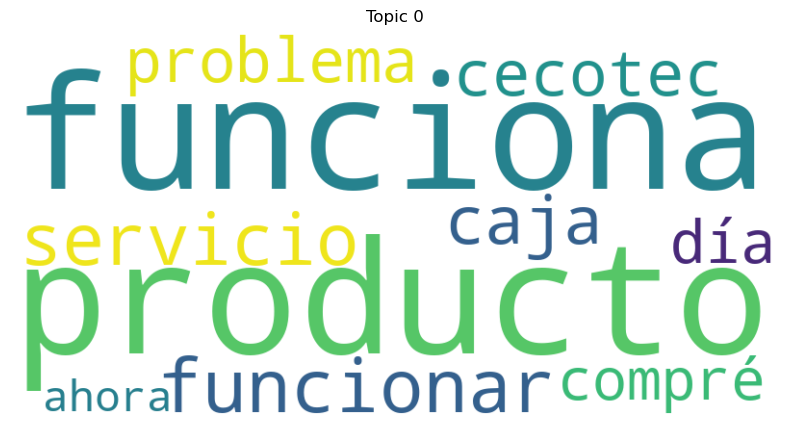

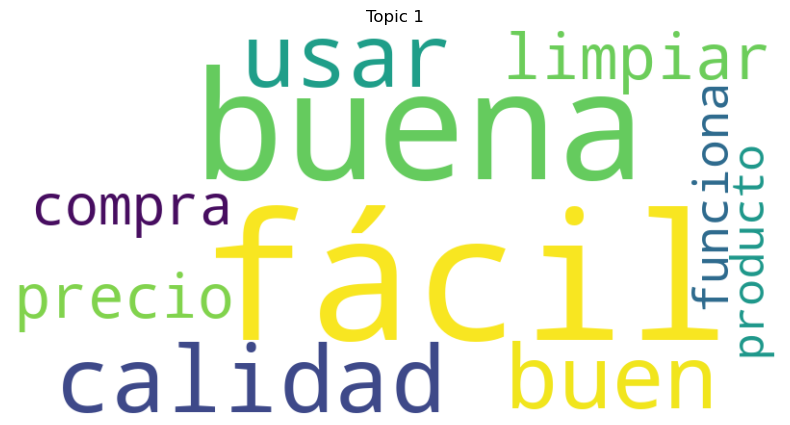

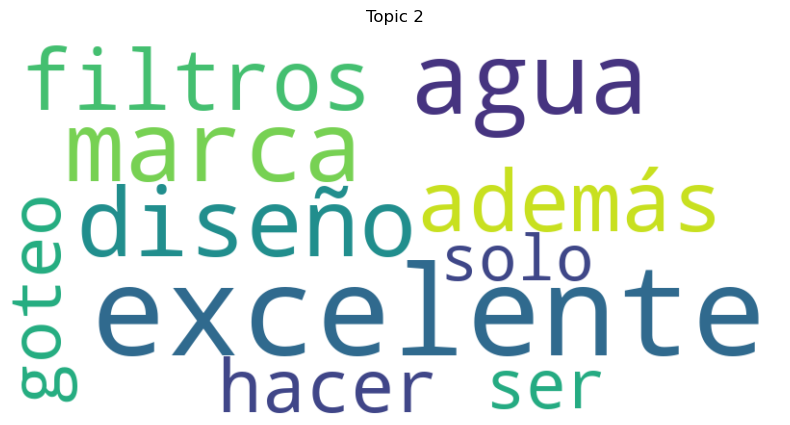

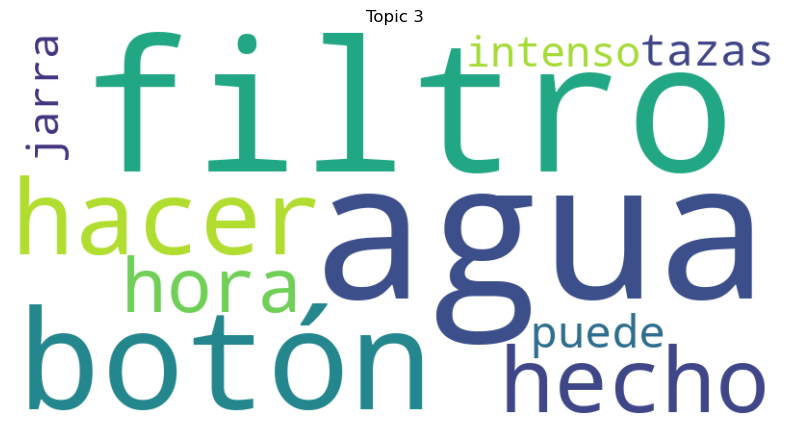

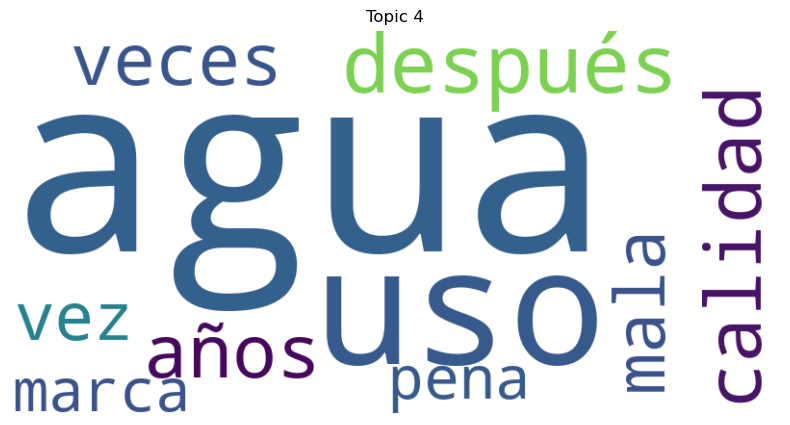

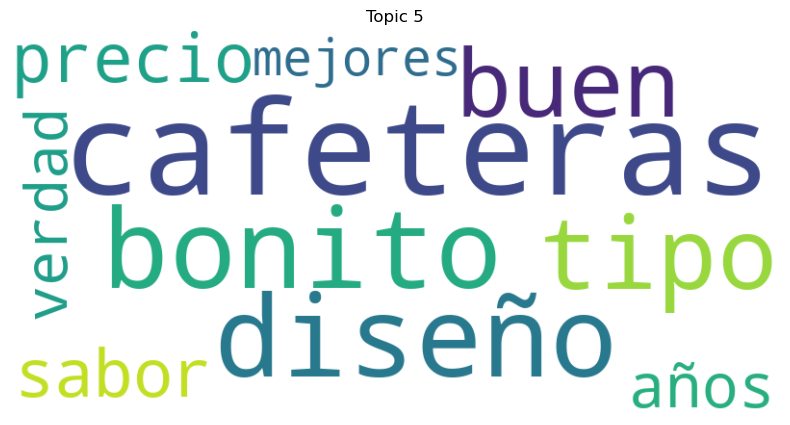

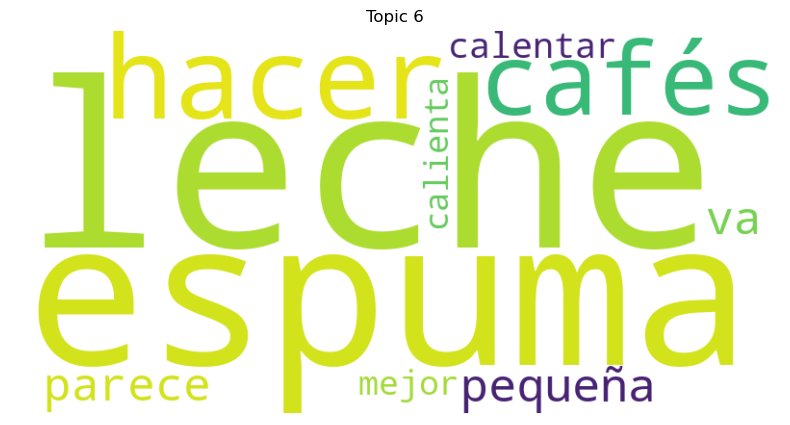

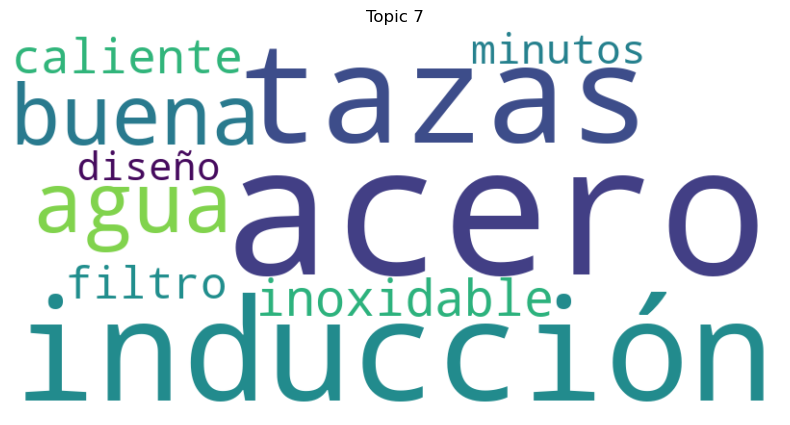

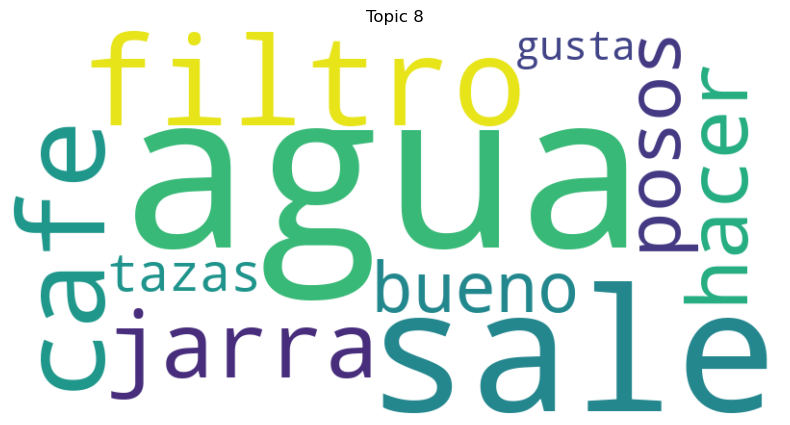

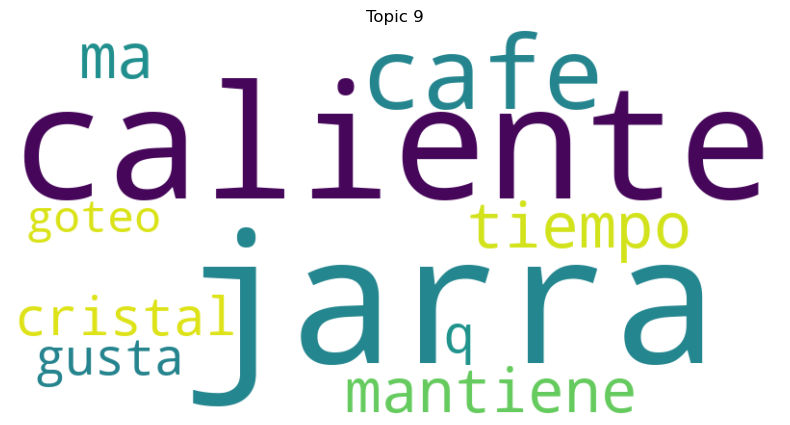

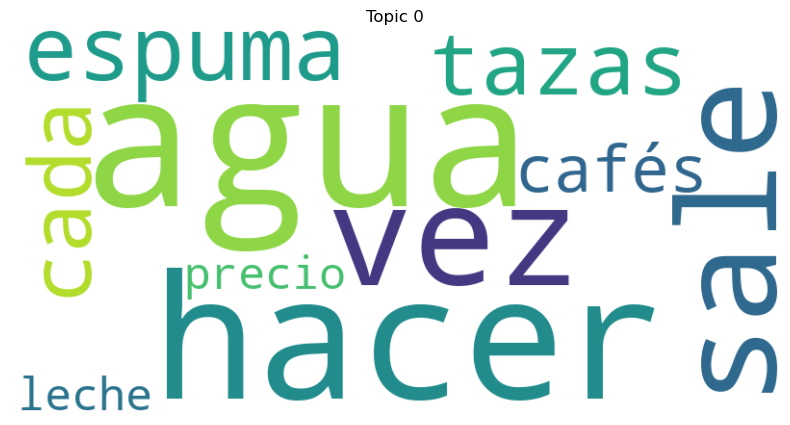

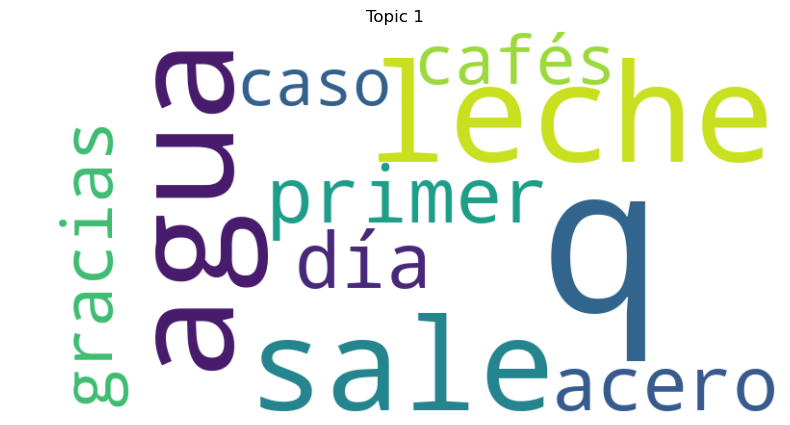

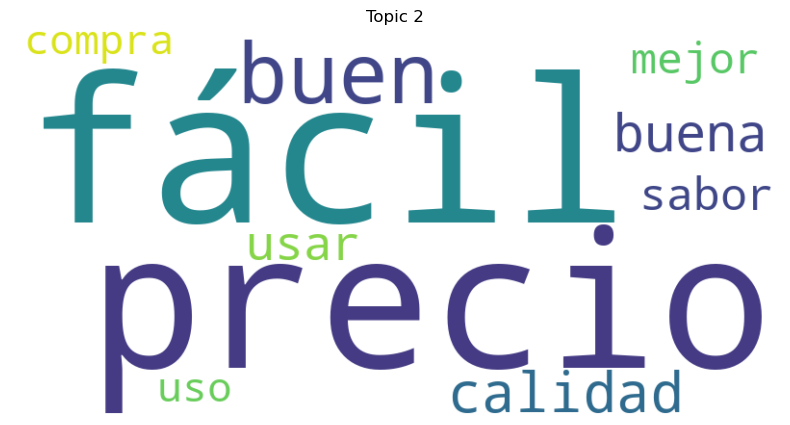

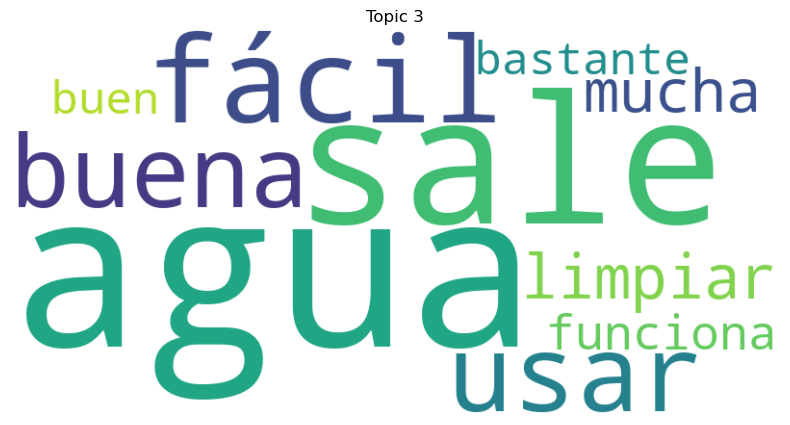

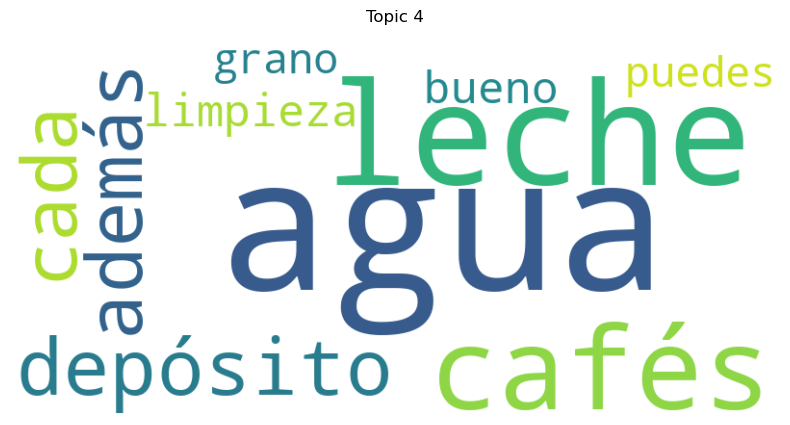

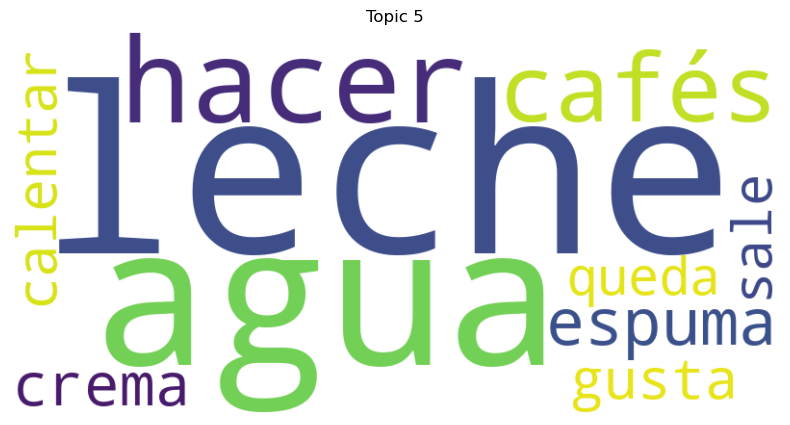

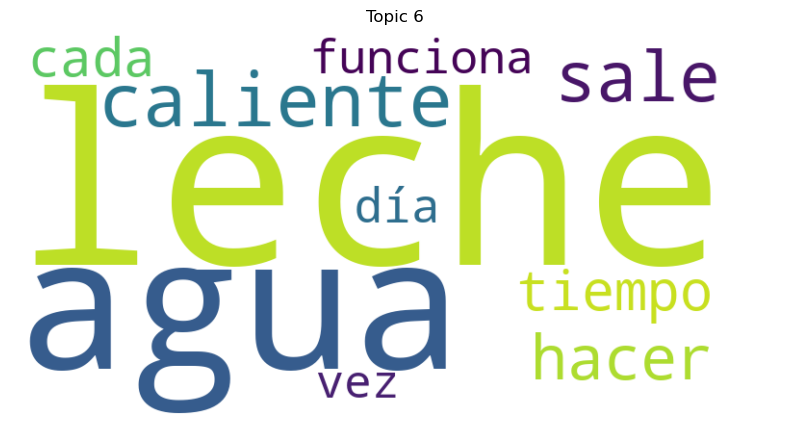

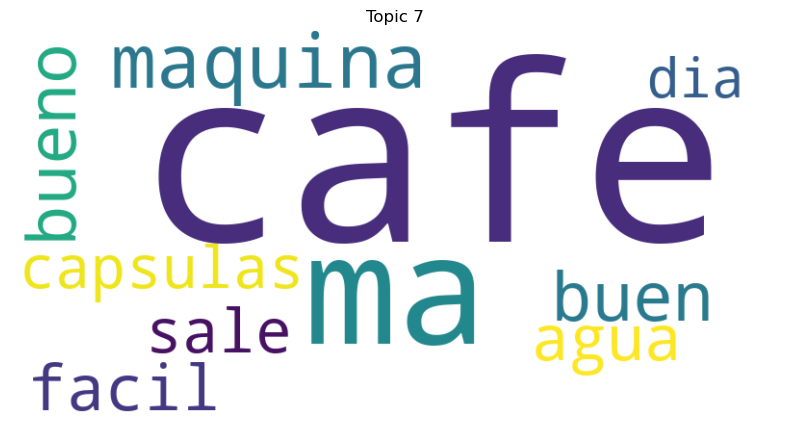

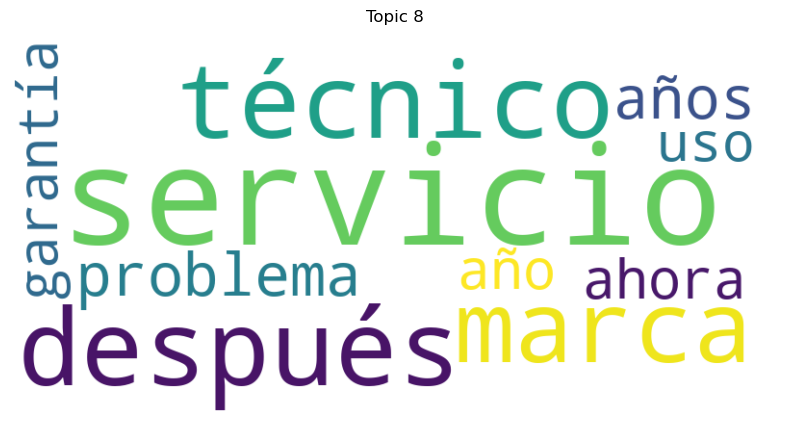

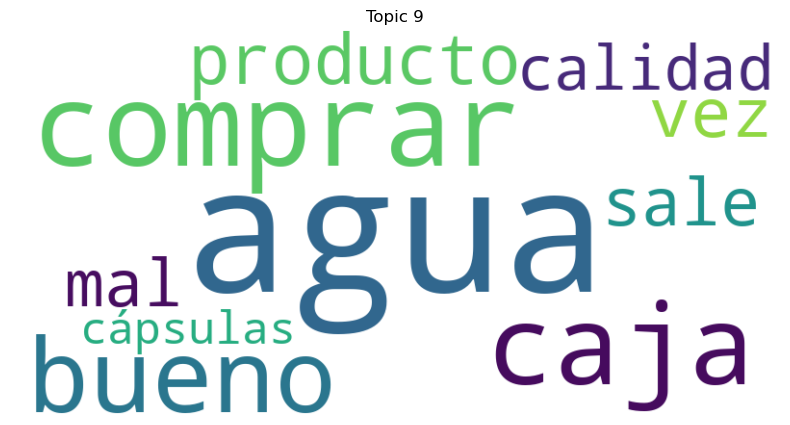

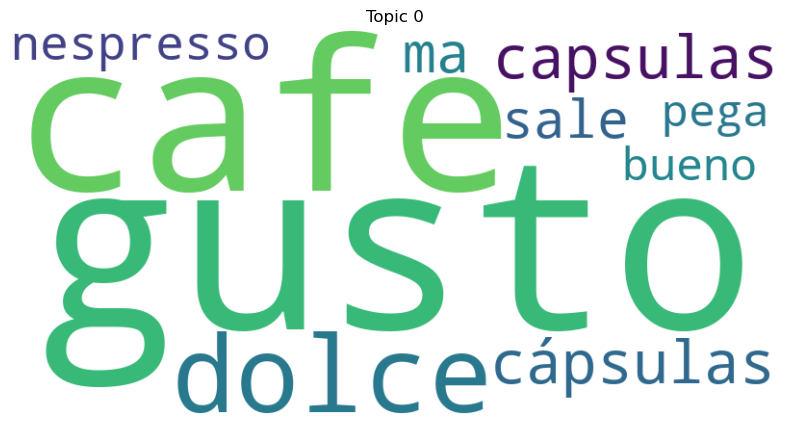

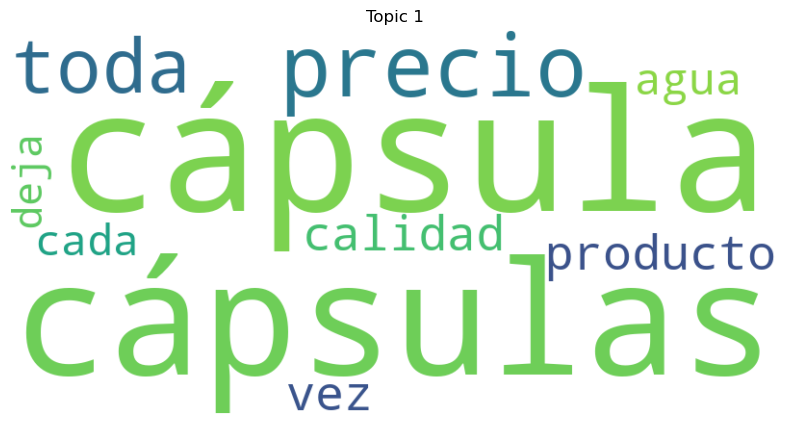

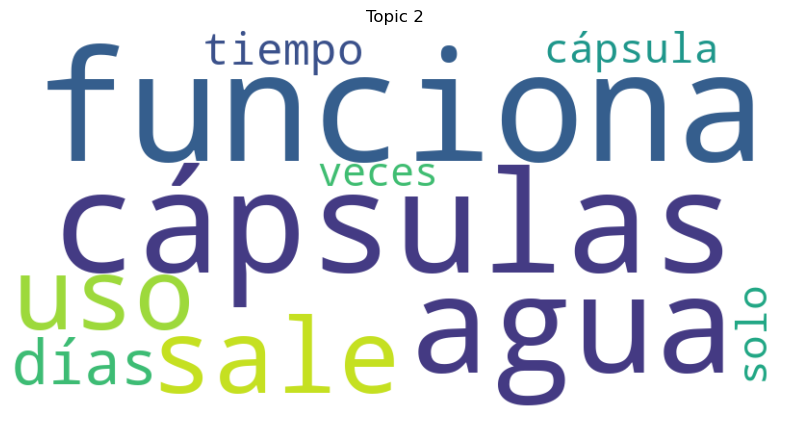

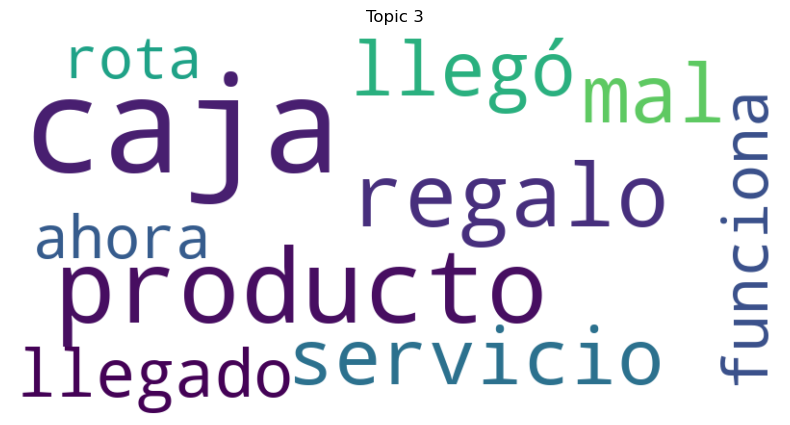

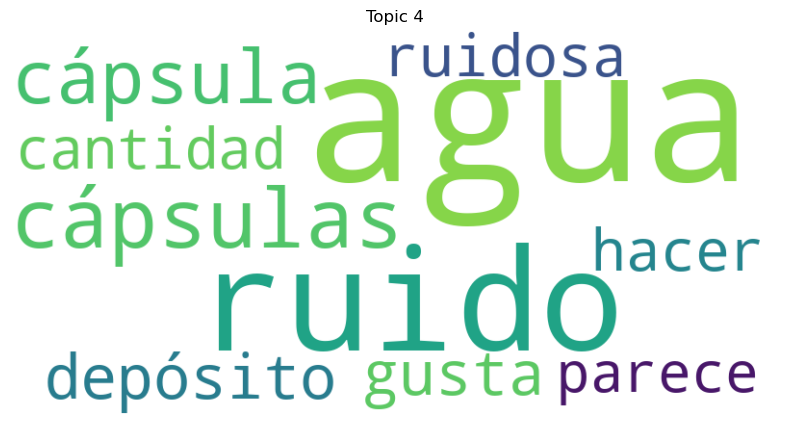

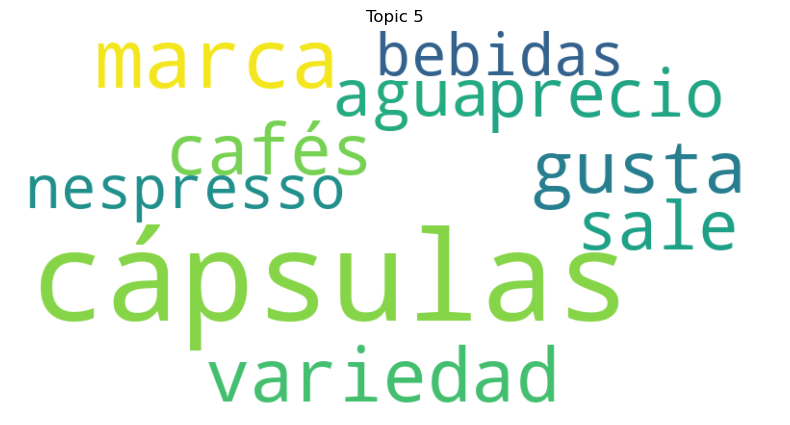

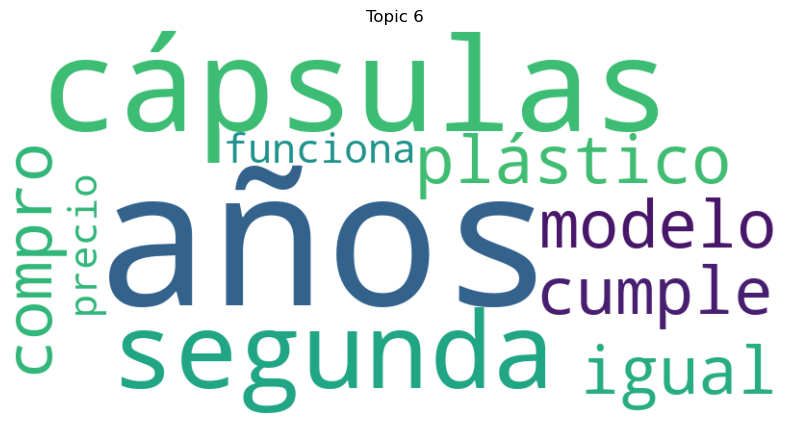

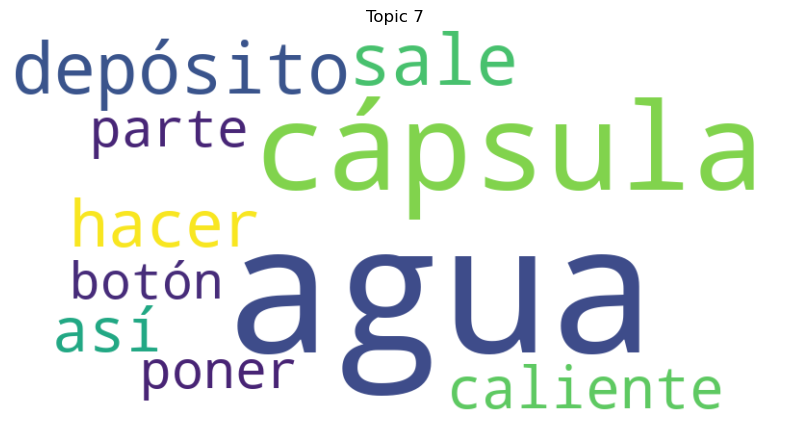

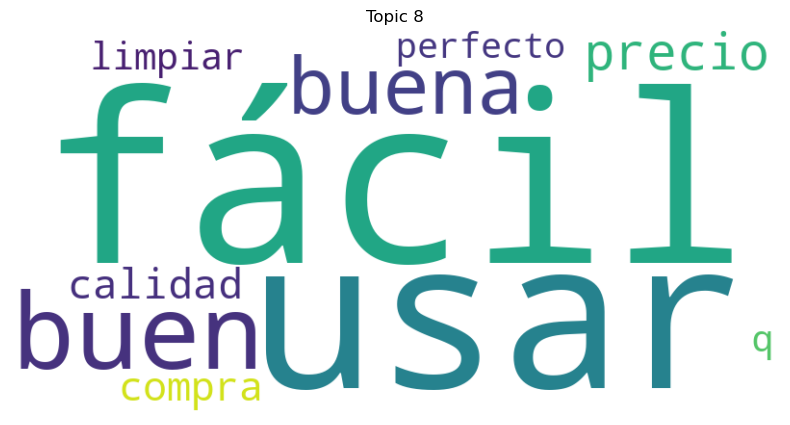

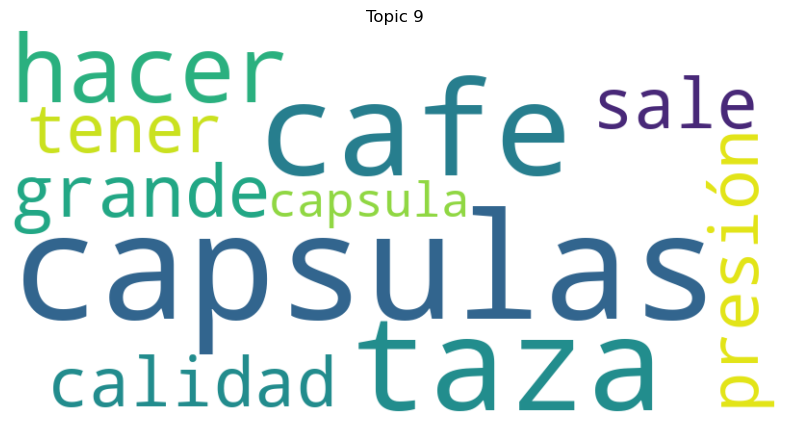

In [47]:
# getting probability from cells
def parse_word_probability(cell_value):
    match = re.match(r'(\S+) \(([\d.]+)\)', cell_value)
    if match:
        return match.group(1), float(match.group(2))
    else:
        return None, None

def load_topics(file_name):
    
    df = pd.read_csv(file_name)
    topics = {}
    
    for col in df.columns:
        if col.startswith('Topic '):
            topic_number = int(col.replace('Topic ', '').strip())
            word_freq = {}
            for index, cell_value in enumerate(df[col]):
                word, probability = parse_word_probability(cell_value)
                if word is not None and probability is not None:
                    word_freq[word] = probability
            topics[topic_number] = word_freq

    return topics

def plot_wordclouds(topics): # plotting clouds
    
    for topic_number, word_freq in topics.items():
        
        plt.figure(figsize=(10, 5))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_number}")
        plt.show()

if __name__ == "__main__":
    
    for i in range(3):
        file_name = f'new_database/analysis/LDA/LDA_category_{i}.csv'
        topics = load_topics(file_name)
        plot_wordclouds(topics)

In [61]:
def load_topics(file_name):
    df = pd.read_csv(file_name)
    topics = {}
    
    for topic_num in range(10):  # Assuming 10 topics
        column_name = f'Topic {topic_num}'
        words_probs = df[column_name].dropna()
        word_list = []
        prob_list = []
        
        for item in words_probs:
            words = item.split()
            for word_prob in words:
                word, prob = word_prob.rsplit('(', 1)
                prob = float(prob.strip(')'))
                word_list.append(word)
                prob_list.append(prob)
        
        topics[topic_num] = list(zip(word_list, prob_list))
    
    return topics

def prepare_lda_visualization(corpus_file, dictionary_file, model_file):
    dictionary = corpora.Dictionary.load(dictionary_file)
    
    corpus = gensim.corpora.MmCorpus(corpus_file)
    
    lda_model = gensim.models.LdaModel.load(model_file)

    # Prepare the pyLDAvis visualization
    #vis = gensimvis.prepare(lda_model, corpus, dictionary)

    vis = pyLDAvis.lda_model.prepare(lda_model, corpus, dictionary)
    
    # Save visualization to HTML file
    pyLDAvis.save_html(vis, 'new_database/analysis/LDA/lda_visualization.html')

if __name__ == "__main__":

    for i in range(3):
        # Files for the LDA visualization
        corpus_file = f'new_database/analysis/LDA/corpus_{i}.mm'  # Path to the corpus file
        dictionary_file = f'new_database/analysis/LDA/dictionary_{i}.dict'  # Path to the dictionary file
        model_file = f'new_database/analysis/LDA/model_{i}.model'  # Path to the trained LDA model
    
        # Prepare and save the LDA visualization
        prepare_lda_visualization(corpus_file, dictionary_file, model_file)
        print("LDA visualization saved to new_database/analysis/LDA/lda_visualization.html")

AttributeError: module 'pyLDAvis' has no attribute 'lda_model'

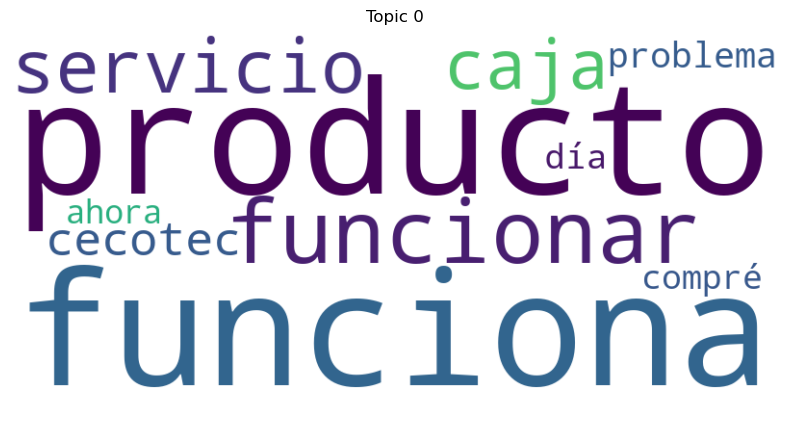

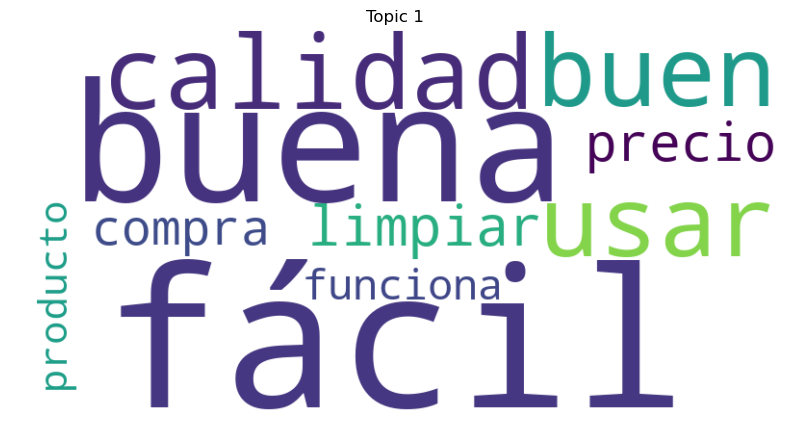

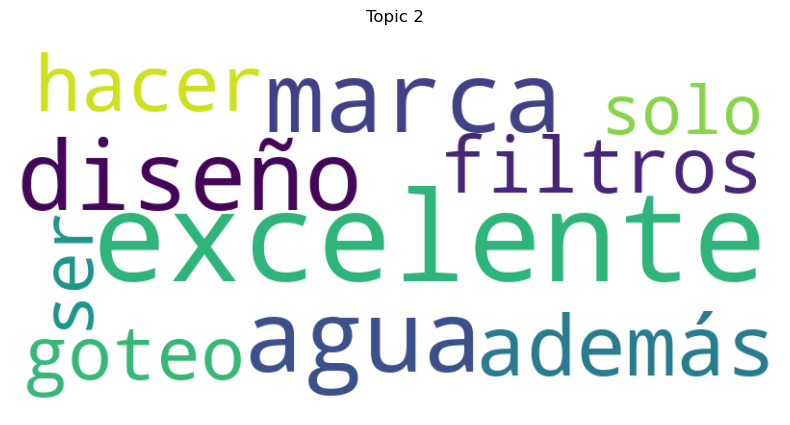

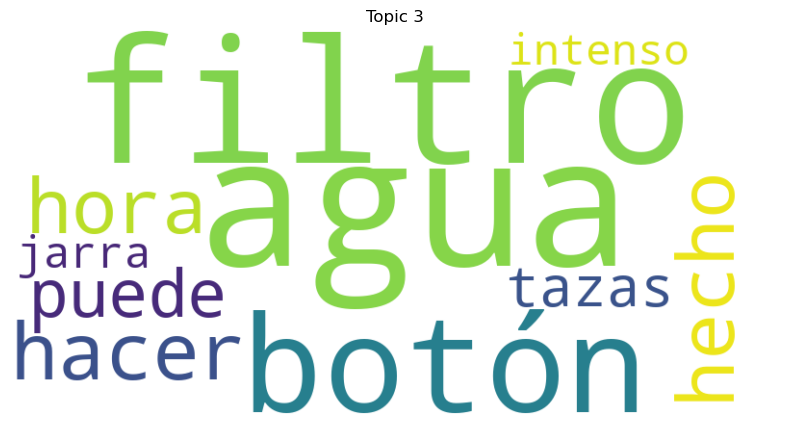

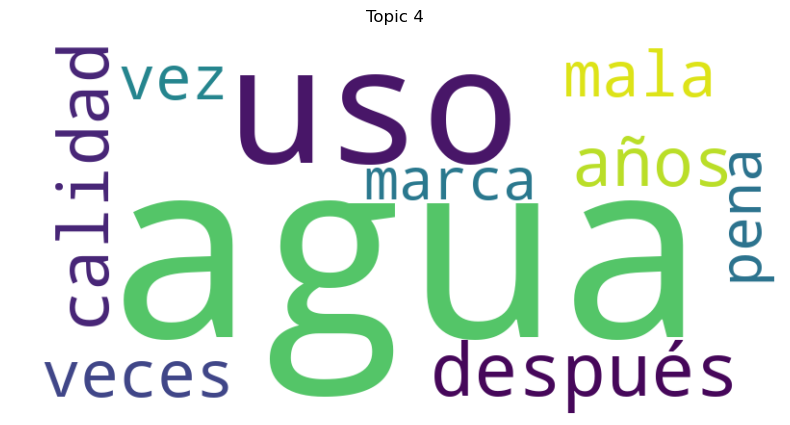

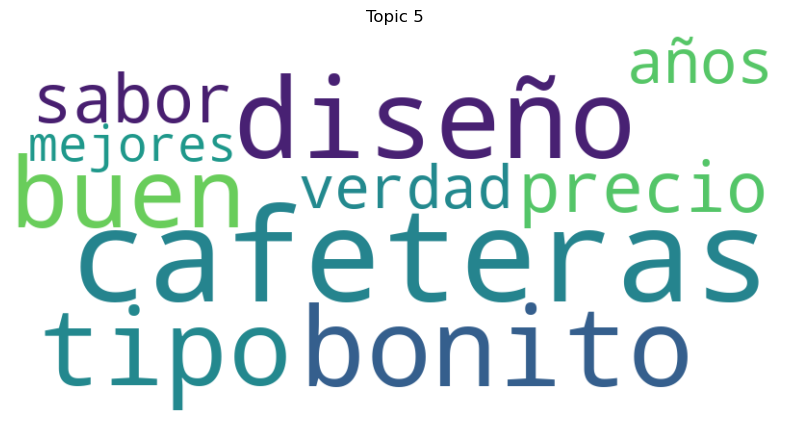

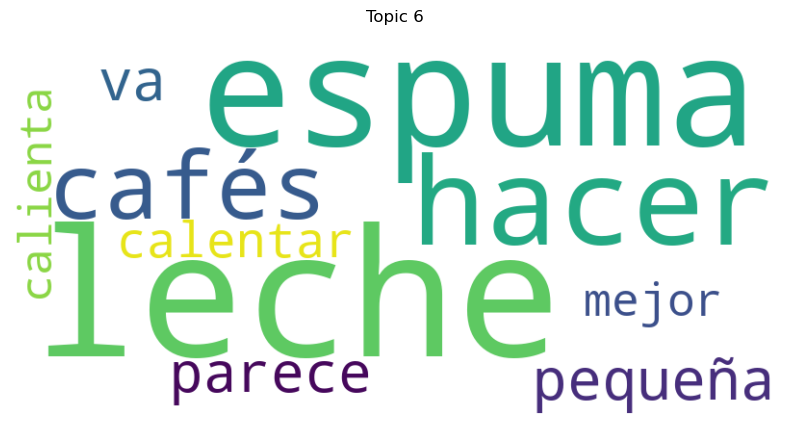

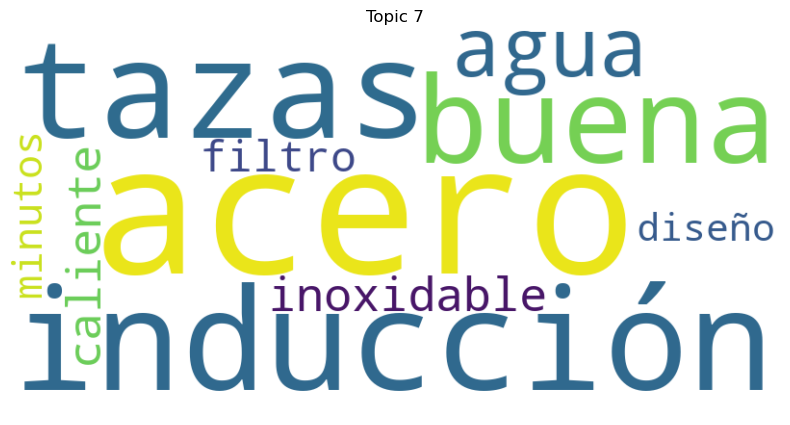

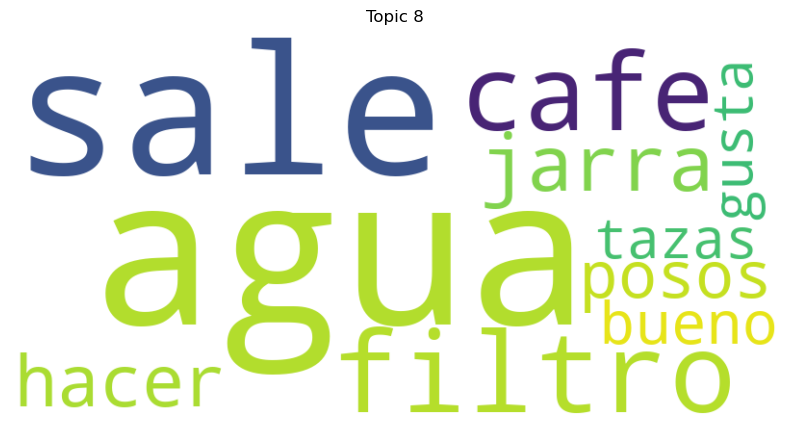

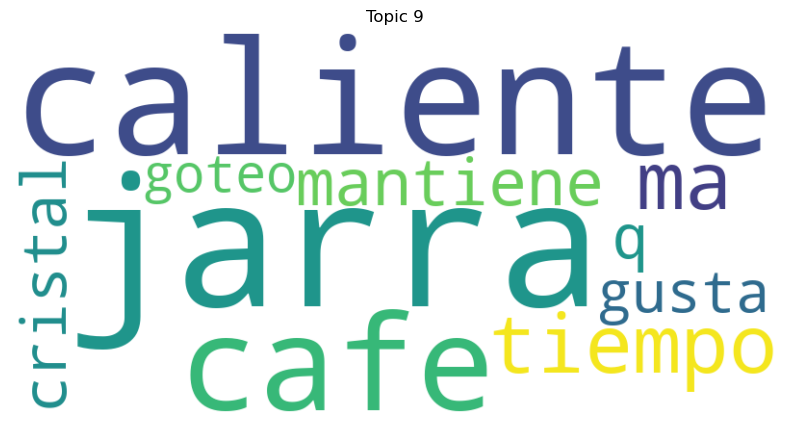

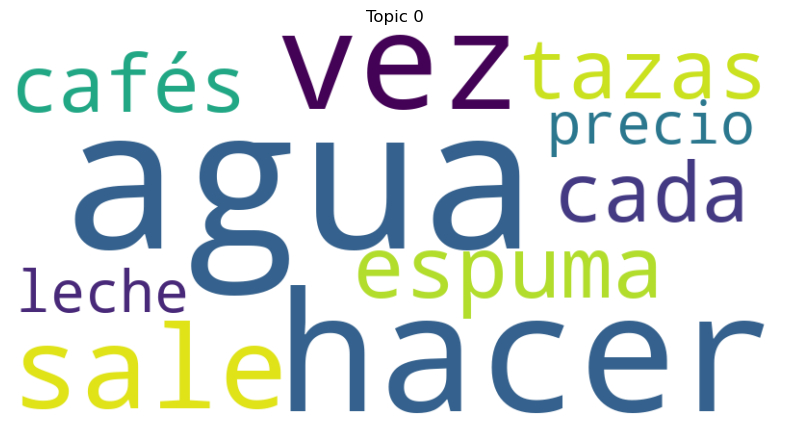

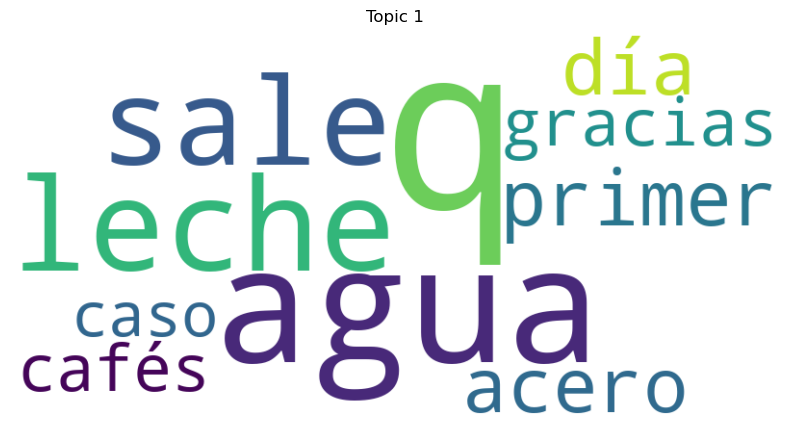

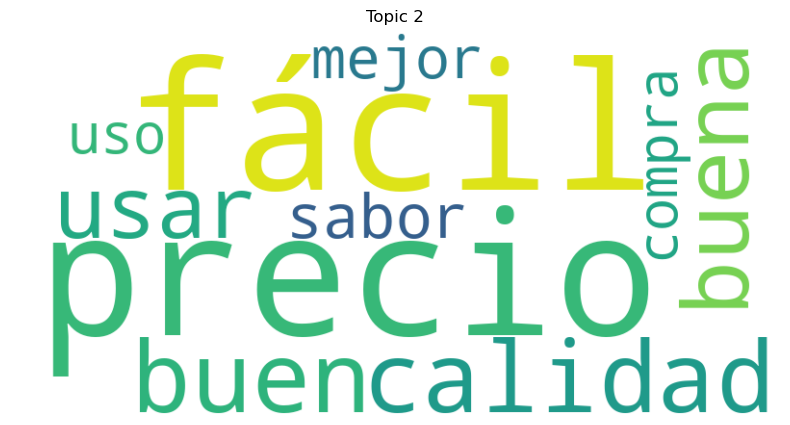

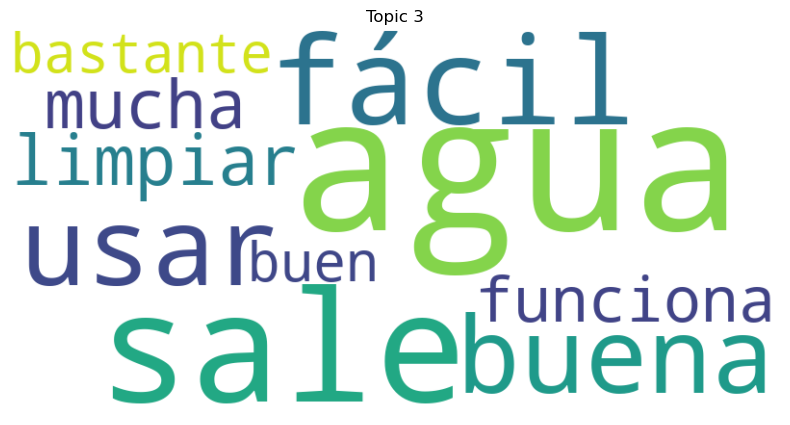

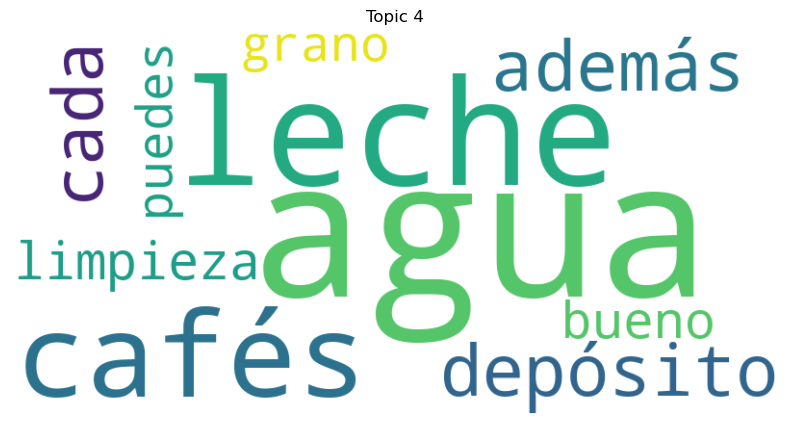

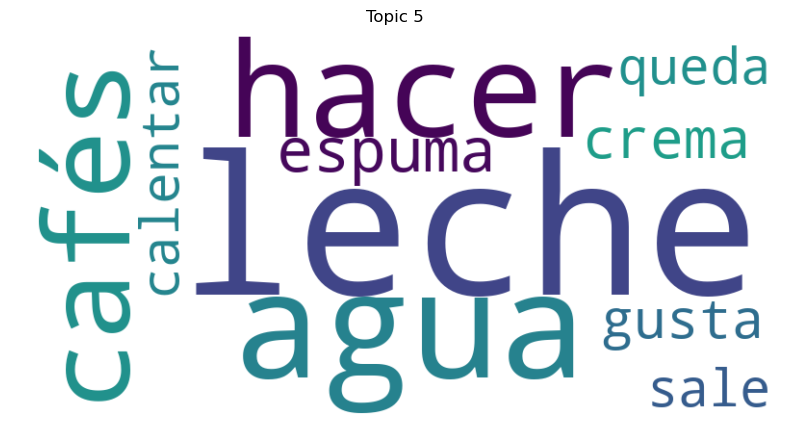

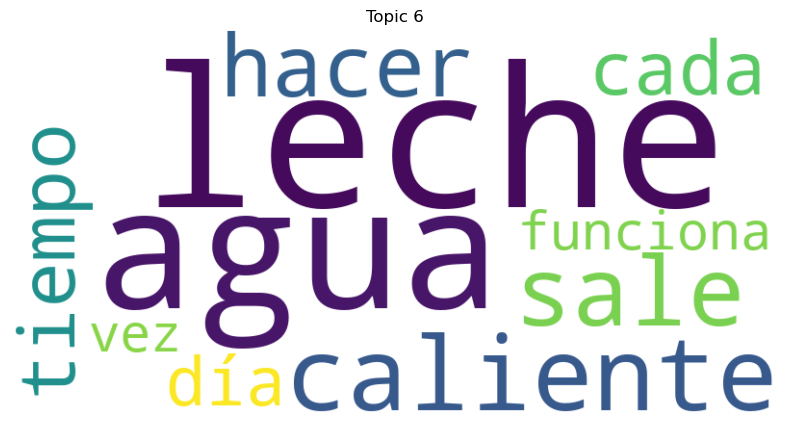

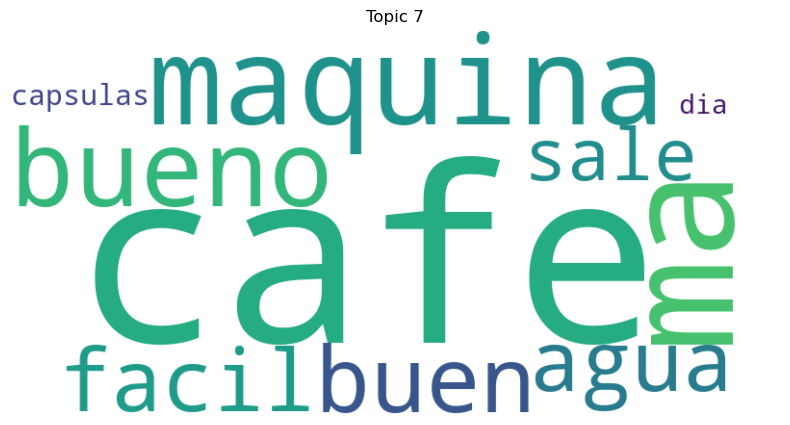

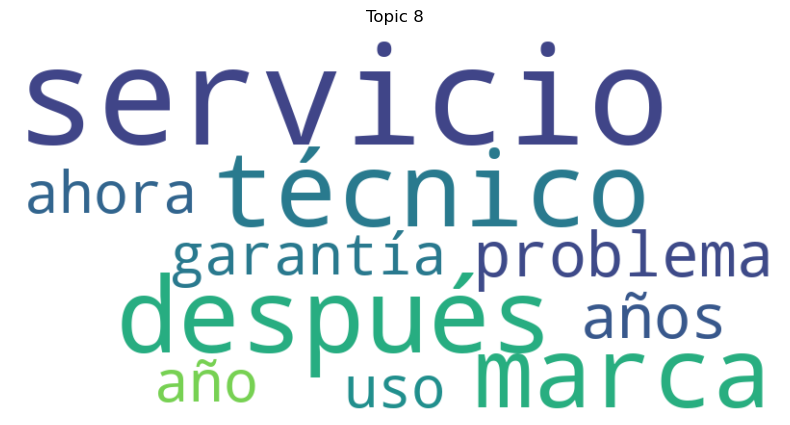

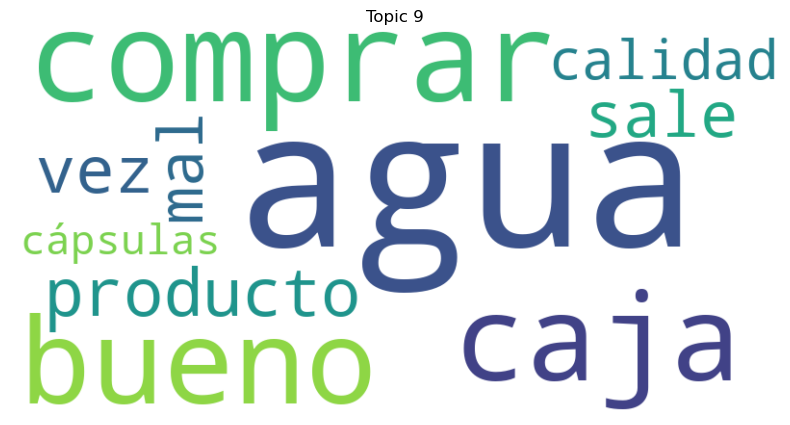

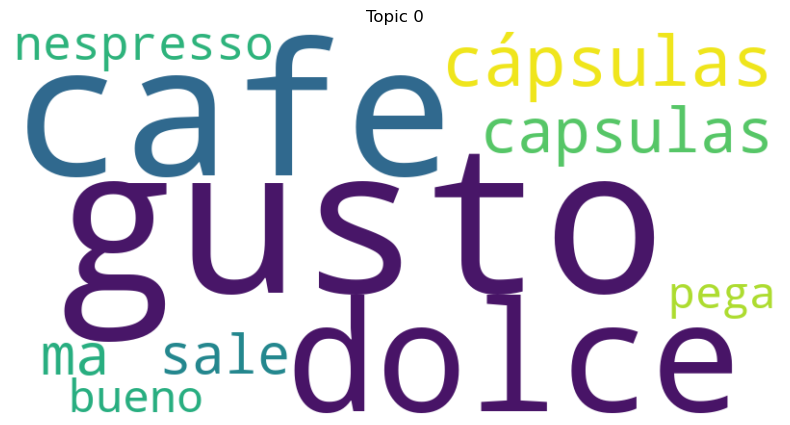

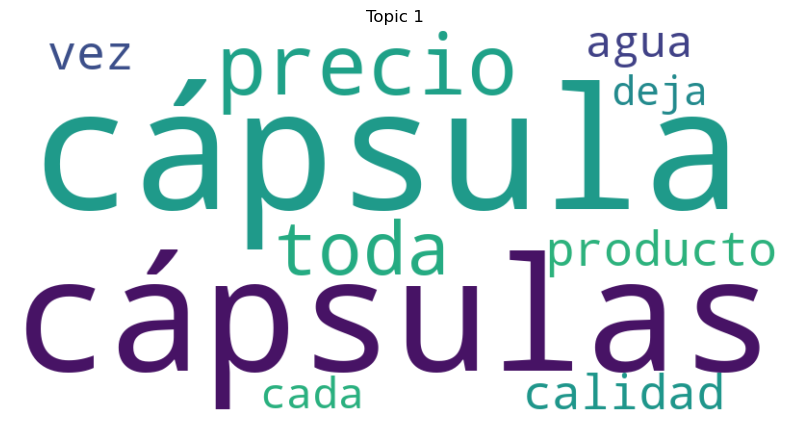

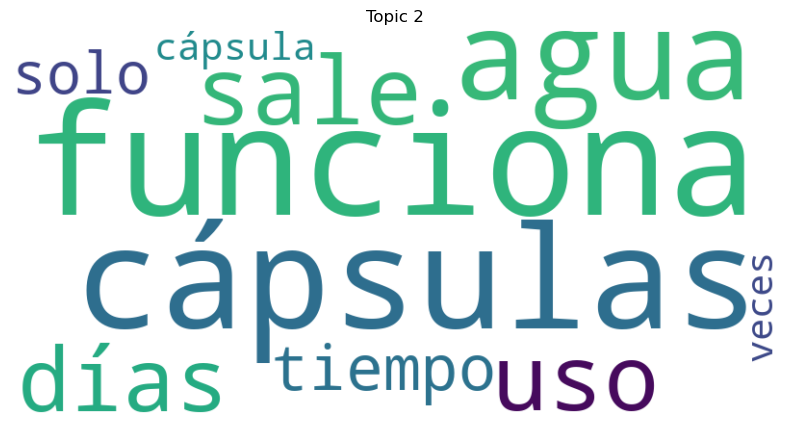

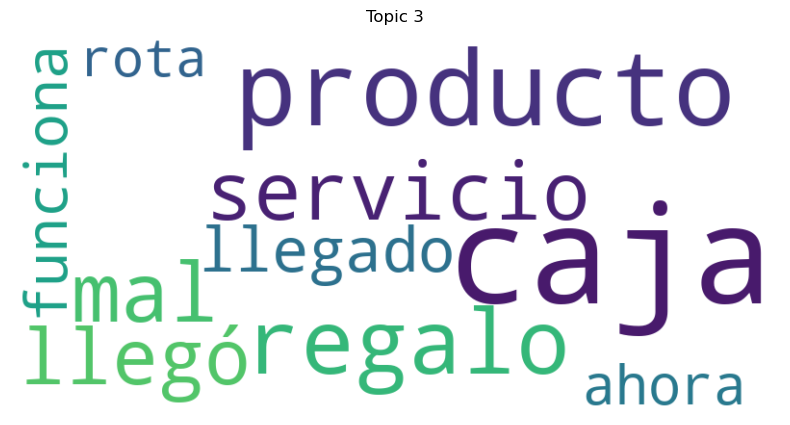

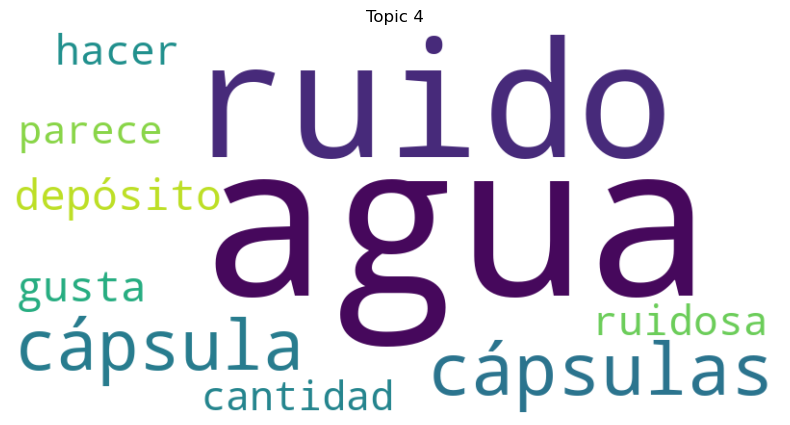

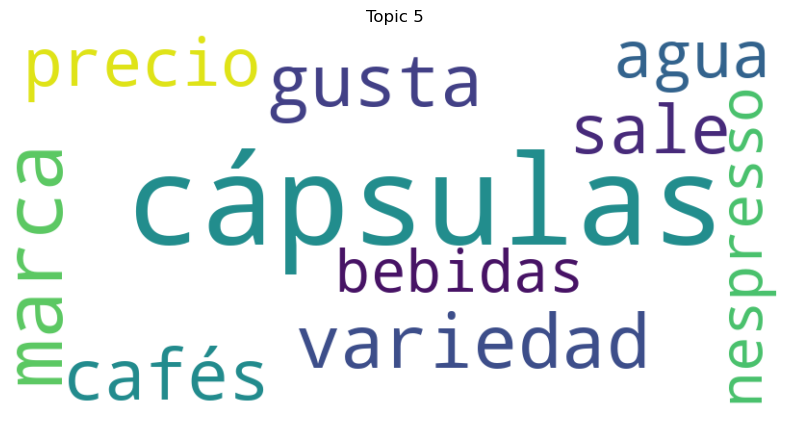

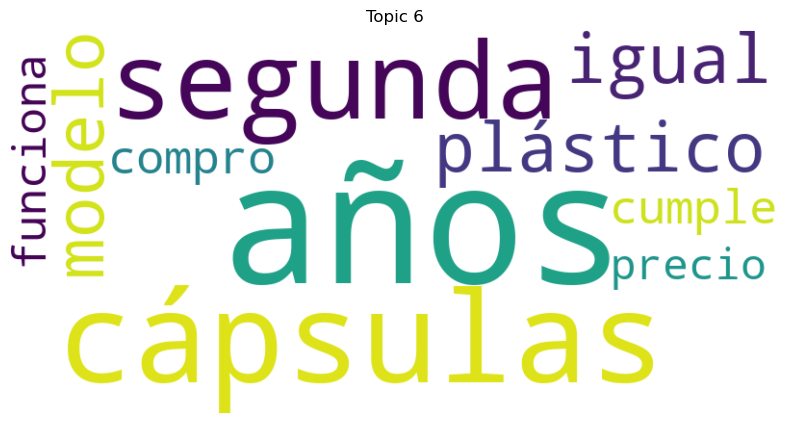

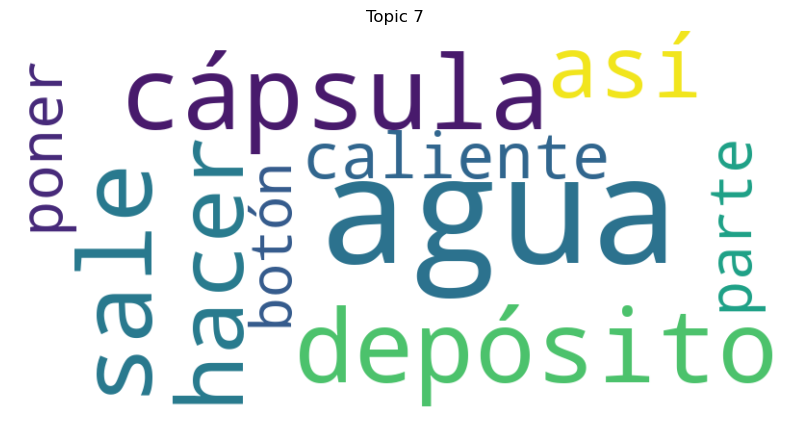

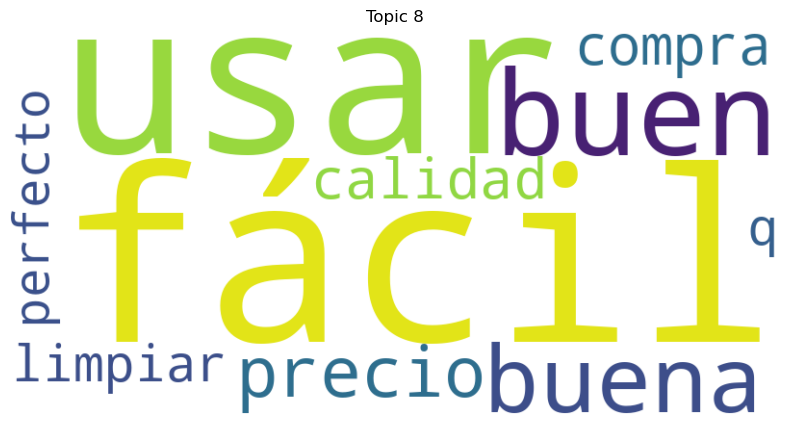

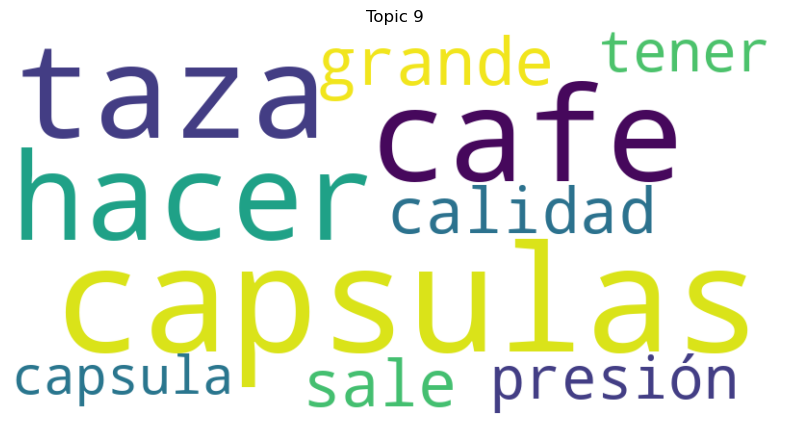

In [65]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# getting probability from cells
def parse_word_probability(cell_value):
    match = re.match(r'(\S+) \(([\d.]+)\)', cell_value)
    if match:
        return match.group(1), float(match.group(2))
    else:
        return None, None

def load_topics(file_name):
    df = pd.read_csv(file_name)
    topics = {}

    for col in df.columns:
        if col.startswith('Topic '):
            topic_number = int(col.replace('Topic ', '').strip())
            word_freq = {}
            for index, cell_value in enumerate(df[col]):
                word, probability = parse_word_probability(cell_value)
                if word is not None and probability is not None:
                    word_freq[word] = probability
            topics[topic_number] = word_freq

    return topics

def plot_wordclouds_in_html(topics, category_name): 
    html_content = f"""
    <b style="font-size: 20px; margin-bottom: 20px;">
        <h1 style="font-size: 25px; text-align: center;">Word Clouds for {category_name} Category</h1>
    </b>
    """

    for topic_number, word_freq in topics.items():
        # Creating word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        
        # Saving the plot to a temporary file
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic_number}")
        plt.show()

    # Displaying the HTML content
    display(HTML(html_content))

if __name__ == "__main__":
    # Assuming you have a list of categories or just names for them
    categories = ["Category 1", "Category 2", "Category 3"]

    for i in range(3):
        file_name = f'new_database/analysis/LDA/LDA_category_{i}.csv'
        topics = load_topics(file_name)
        plot_wordclouds_in_html(topics, categories[i])
